In [ ]:
# ==============================================================================
# CELL 1: KONFIGURASI SISTEM & LIBRARY
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
import warnings
import sys
import os
import time
import optuna
import random
import joblib 
import json   

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score, 
                             precision_score, f1_score, roc_auc_score, 
                             roc_curve, classification_report, auc) # Added auc
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import ParameterGrid

# SETUP TAMPILAN PROFESIONAL
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING) 
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 11,
    'figure.dpi': 120,
    'axes.titlesize': 14,
    'axes.labelsize': 12
})

# KONFIGURASI UTAMA (LOCKED)
FILE_PATH = 'DataBMKG20242016.csv' 
TARGET_THRESHOLD = 20.0
TEST_SIZE = 0.15
RANDOM_STATE = 42


os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("[v] Library Loaded. Random Seed Locked (42). Ready to go.")

c:\Users\LENOVO\Documents\Paper\Penelitian-Skripsi-Cuaca\venv\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.0) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)
c:\Users\LENOVO\Documents\Paper\Penelitian-Skripsi-Cuaca\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[v] Library Loaded. Random Seed Locked (42). Ready to go.


>>> MEMULAI AUDIT DATA MENTAH...
[!] Ditemukan 11 tanggal ganda. Mengambil data pertama...

LAPORAN DATA MENTAH (BEFORE CLEANING)
1. Dimensi Data   : 3293 Baris, 6 Kolom
2. Duplikasi Data : 0 baris

3. Cek Missing Values & Tipe Data:
              Tipe Data  Null Values  Persentase Null
TANGGAL  datetime64[ns]            0              0.0
TAVG             object            0              0.0
RH_AVG           object            0              0.0
RR               object            0              0.0
SS               object            0              0.0
FF_AVG            int64            0              0.0

4. Statistik Deskriptif (Mentah):
          count                           mean                  min  \
TANGGAL    3282  2020-07-03 22:55:30.164533760  2016-01-01 00:00:00   
FF_AVG   3282.0                       0.425046                  0.0   

                         max  
TANGGAL  2024-12-31 00:00:00  
FF_AVG                   2.0  


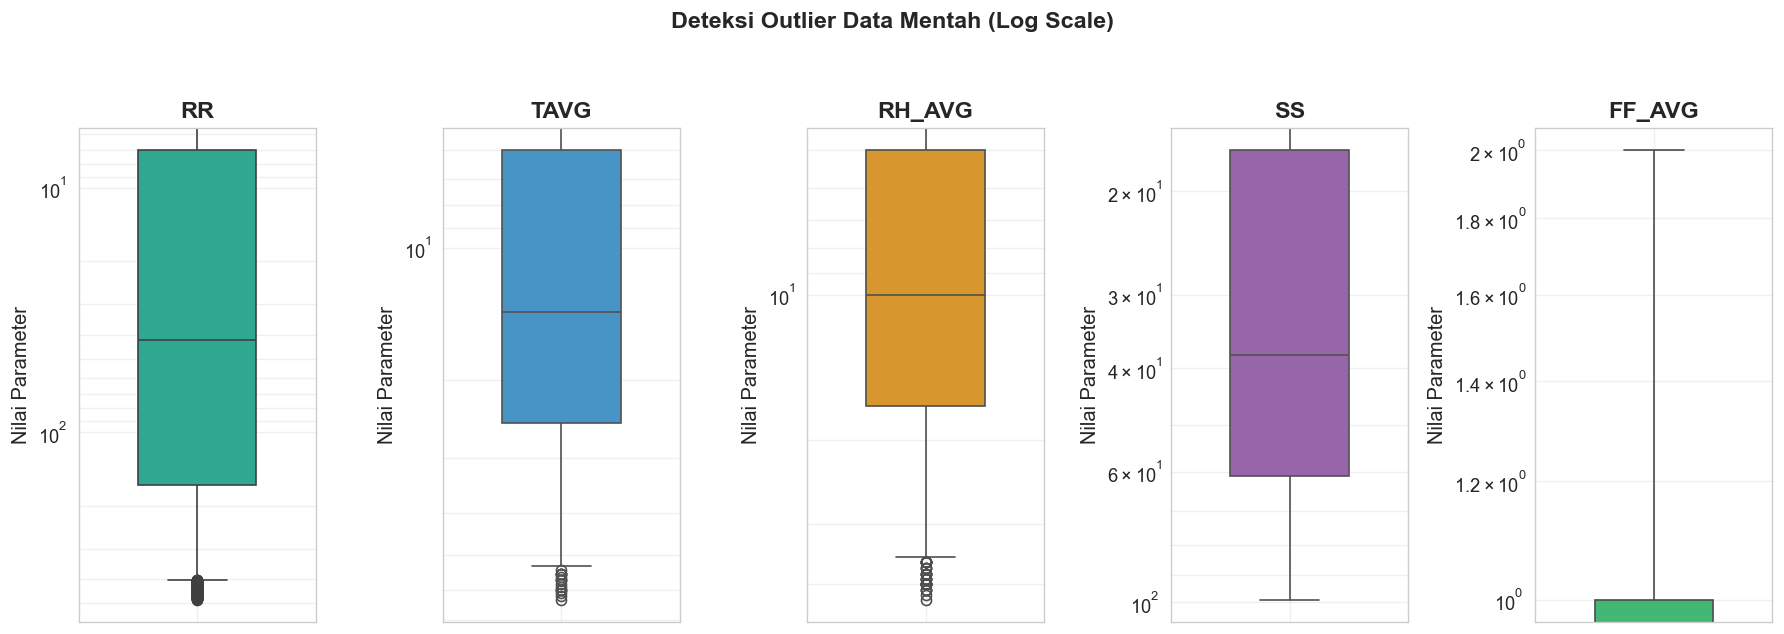


>>> MENJALANKAN PROSES CLEANING...
[Info] Total nilai non-valid (8888/9999/NaN) yang ditemukan: 441
[Action] Menghapus 351 baris karena data Target (RR) kosong.

LAPORAN DATA BERSIH (READY TO USE)
Dimensi Akhir : 2931 Baris
Sisa Null     : 
 TANGGAL    0
TAVG       0
RH_AVG     0
RR         0
SS         0
FF_AVG     0
dtype: int64

Sample Data Bersih:
        TANGGAL  TAVG  RH_AVG    RR   SS  FF_AVG
2932 2016-01-01  21.5    90.0   1.2  0.1     0.0
2933 2016-01-03  21.6    89.0  43.9  1.4     0.0
2934 2016-01-04  22.0    90.0   8.7  1.6     0.0
2936 2016-01-06  22.3    84.0  33.2  1.8     0.0
2937 2016-01-07  22.6    83.0   9.0  5.1     0.0

[v] CELL 2 SELESAI. Data sudah bersih dan siap diolah.


In [ ]:
# ==============================================================================
# CELL 2: DEEP AUDIT DATA, DETEKSI OUTLIER, & CLEANING
# ==============================================================================
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(">>> MEMULAI AUDIT DATA MENTAH...")

if not os.path.exists(FILE_PATH):
    sys.exit("ERROR: File CSV tidak ditemukan! Pastikan path file benar.")

# 1. LOAD DATA MENTAH
df = pd.read_csv(FILE_PATH)
df.rename(columns={'TAVG': 'TAVG', 'RH_AVG': 'RH_AVG', 'FF_AVG': 'FF_AVG', 'SS': 'SS'}, inplace=True)
original_shape = df.shape

# Parsing Tanggal (Penting untuk Time Series)
if 'TANGGAL' in df.columns:
    df['TANGGAL'] = pd.to_datetime(df['TANGGAL'], format='%d-%m-%Y', errors='coerce')
    df = df.sort_values('TANGGAL')
    # Cek Duplikasi Tanggal
    duplicate_dates = df.duplicated(subset=['TANGGAL']).sum()
    if duplicate_dates > 0:
        print(f"[!] Ditemukan {duplicate_dates} tanggal ganda. Mengambil data pertama...")
        df = df.drop_duplicates(subset=['TANGGAL'], keep='first')

# 2. LAPORAN INTEGRITAS DATA (SEBELUM CLEANING)
print("\n" + "="*50)
print("LAPORAN DATA MENTAH (BEFORE CLEANING)")
print("="*50)
print(f"1. Dimensi Data   : {original_shape[0]} Baris, {original_shape[1]} Kolom")
print(f"2. Duplikasi Data : {df.duplicated().sum()} baris")

print("\n3. Cek Missing Values & Tipe Data:")
info_tab = pd.DataFrame({
    'Tipe Data': df.dtypes,
    'Null Values': df.isnull().sum(),
    'Persentase Null': (df.isnull().sum() / len(df)) * 100
})
print(info_tab)

print("\n4. Statistik Deskriptif (Mentah):")
print(df.describe().T[['count', 'mean', 'min', 'max']])

# 3. VISUALISASI OUTLIER DATA MENTAH (REQUESTED)
# Kita plot Boxplot untuk melihat sebaran data 'kotor' sebelum dibersihkan
cols_numeric = ['RR', 'TAVG', 'RH_AVG', 'SS', 'FF_AVG']
valid_cols = [c for c in cols_numeric if c in df.columns]

plt.figure(figsize=(15, 5))
plt.suptitle('Deteksi Outlier Data Mentah (Log Scale)', fontsize=14, fontweight='bold', y=1.05)
colors = ['#1abc9c', '#3498db', '#f39c12', '#9b59b6', '#2ecc71']  # Warna kontras serupa gambar

for i, col in enumerate(valid_cols):
    plt.subplot(1, len(valid_cols), i+1)
    sns.boxplot(y=df[col], color=colors[i], width=0.5)
    plt.yscale('log')  # gunakan skala logaritmik
    plt.title(f'{col}', fontweight='bold')
    plt.ylabel('Nilai Parameter')
    plt.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# 4. PROSES CLEANING (ROBUST)
print("\n>>> MENJALANKAN PROSES CLEANING...")

# Fungsi pembersih kode BMKG (8888, 9999, nan)
def clean_bmkg_robust(val):
    s = str(val).strip()
    if s in ['8888', '9999', '-', '', 'nan', 'None']: return np.nan
    try:
        f = float(s)
        return np.nan if f in [8888, 9999] else f
    except: return np.nan

# Terapkan Cleaning
for col in valid_cols:
    df[col] = df[col].apply(clean_bmkg_robust)

# Cek Null setelah cleaning angka 8888/9999
null_after_clean = df[valid_cols].isnull().sum().sum()
print(f"[Info] Total nilai non-valid (8888/9999/NaN) yang ditemukan: {null_after_clean}")

# 5. HANDLING MISSING VALUES (Interpolasi Time Series)
# Hapus baris jika Target (RR) kosong total (karena ini target prediksi)
missing_rr = df['RR'].isnull().sum()
if missing_rr > 0:
    print(f"[Action] Menghapus {missing_rr} baris karena data Target (RR) kosong.")
    df = df.dropna(subset=['RR'])

# Interpolasi Linear untuk fitur lain (mengisi bolong-bolong kecil)
df[valid_cols] = df[valid_cols].interpolate(method='linear', limit_direction='both')

# 6. LAPORAN AKHIR (AFTER CLEANING)
print("\n" + "="*50)
print("LAPORAN DATA BERSIH (READY TO USE)")
print("="*50)
print(f"Dimensi Akhir : {df.shape[0]} Baris")
print("Sisa Null     : \n", df.isnull().sum())
print("\nSample Data Bersih:")
print(df.head(5))
print("\n[v] CELL 2 SELESAI. Data sudah bersih dan siap diolah.")

>>> GENERATING SINGLE FRAME DASHBOARD...


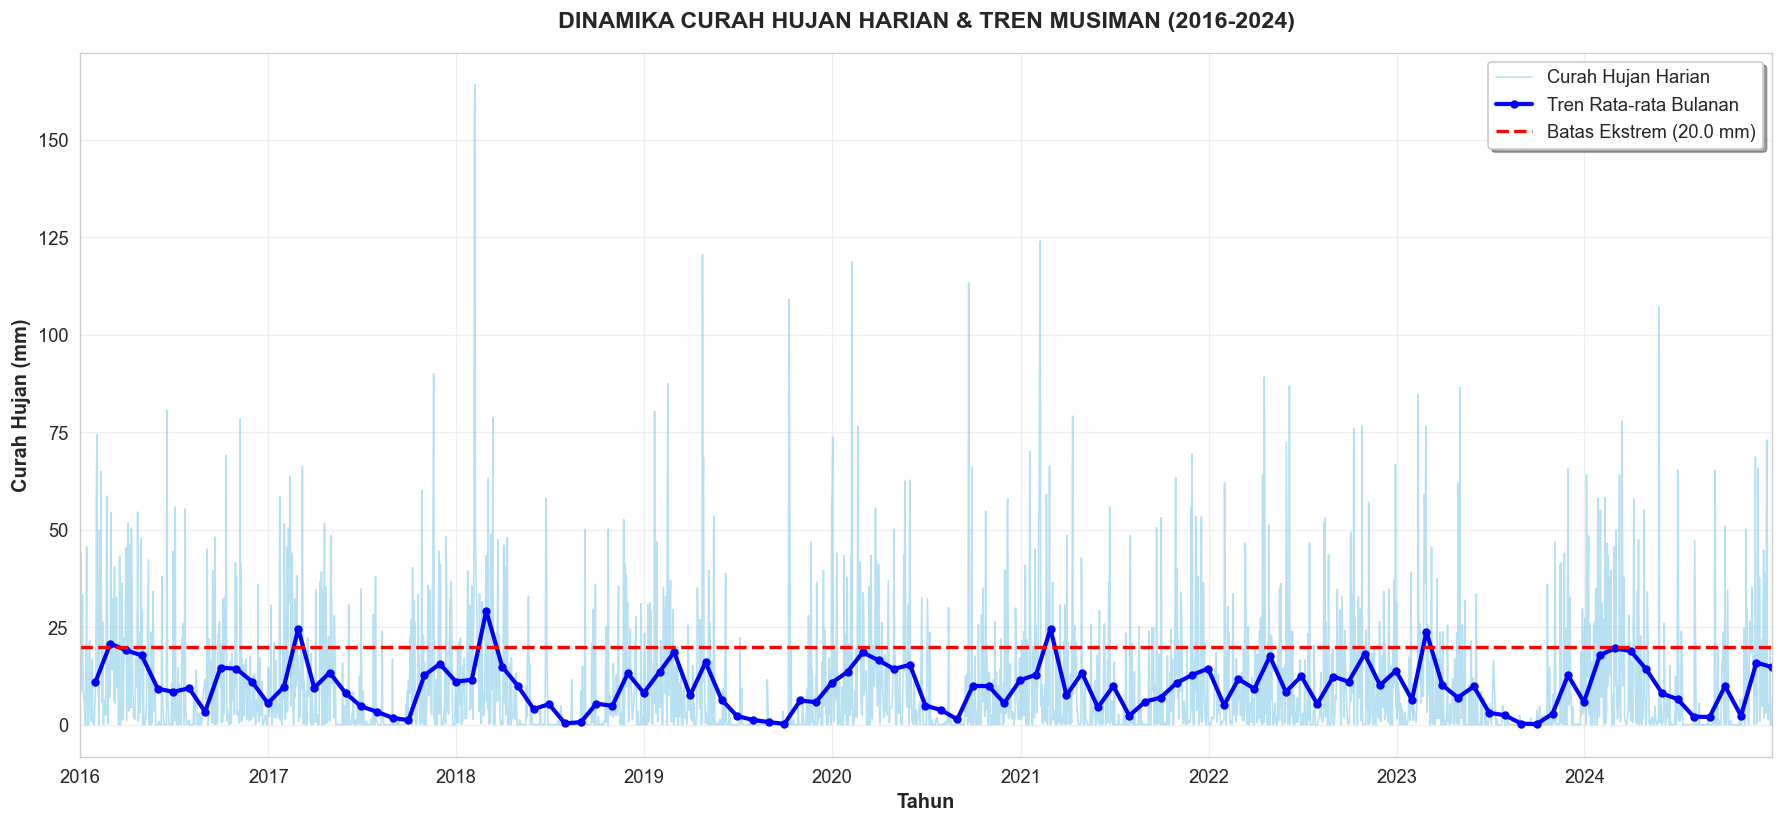

[v] CELL 3 SELESAI. Grafik Overlay Ditampilkan.


In [ ]:
# ==============================================================================
# CELL 3: VISUALISASI DINAMIKA CUACA (SINGLE FRAME OVERLAY)
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns

print(">>> GENERATING SINGLE FRAME DASHBOARD...")

# 1. SIAPKAN DATA
df_monthly = df.set_index('TANGGAL').resample('M')['RR'].mean()

# 2. SETUP CANVAS (SATU KOTAK SAJA)
plt.figure(figsize=(15, 7))

# 3. PLOT LAYER 1: DATA HARIAN (Background)
plt.plot(df['TANGGAL'], df['RR'], color='skyblue', linewidth=1, label='Curah Hujan Harian', alpha=0.6)

# 4. PLOT LAYER 2: TREN BULANAN (Foreground - LEBIH TEBAL)
plt.plot(df_monthly.index, df_monthly.values, color='blue', linewidth=2.5, 
         marker='o', markersize=4, label='Tren Rata-rata Bulanan')

# 5. PLOT LAYER 3: THRESHOLD EKSTREM
plt.axhline(TARGET_THRESHOLD, color='red', linestyle='--', linewidth=2, 
            label=f'Batas Ekstrem ({TARGET_THRESHOLD} mm)')

# 6. KOSMETIK GRAFIK
plt.title('DINAMIKA CURAH HUJAN HARIAN & TREN MUSIMAN (2016-2024)', fontsize=14, fontweight='bold', pad=15)
plt.ylabel('Curah Hujan (mm)', fontweight='bold')
plt.xlabel('Tahun', fontweight='bold')

# Grid & Legend
plt.grid(True, which='major', linestyle='-', alpha=0.3)
plt.grid(True, which='minor', linestyle=':', alpha=0.1)
plt.legend(loc='upper right', frameon=True, shadow=True, fontsize=11)

# Format Sumbu X
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim([df['TANGGAL'].min(), df['TANGGAL'].max()])

plt.tight_layout()
plt.show()

print("[v] CELL 3 SELESAI. Grafik Overlay Ditampilkan.")

In [ ]:
# ==============================================================================
# CELL 4: FEATURE ENGINEERING & DATA SPLITTING (FULL VIEW)
# ==============================================================================
print(">>> GENERATING FEATURES & SPLITTING DATA...")

# 1. GENERATE TARGET LABEL
df['Target'] = (df['RR'] > TARGET_THRESHOLD).astype(int)

# 2. FEATURE ENGINEERING (LAG & ROLLING)
if 'TANGGAL' in df.columns:
    df_proc = df.set_index('TANGGAL').reindex(pd.date_range(df['TANGGAL'].min(), df['TANGGAL'].max()), method='ffill')
    df_proc.index.name = 'TANGGAL' # Pastikan nama index tetap 'TANGGAL'
else:
    df_proc = df.copy()

# Buat Lag Features (1-3 hari sebelumnya)
cols_check = ['RR', 'TAVG', 'RH_AVG', 'SS', 'FF_AVG']
for col in cols_check:
    for i in [1, 2, 3]: 
        df_proc[f'{col}_Lag{i}'] = df_proc[col].shift(i)

# Buat Rolling Features (Tren 3 harian)
df_proc['RR_Roll3_Mean'] = df_proc['RR_Lag1'].rolling(3).mean()
df_proc['RR_Roll3_Max'] = df_proc['RR_Lag1'].rolling(3).max()

# Hapus NaN akibat shifting & Reset Index
df_model = df_proc.dropna().reset_index()

# [FIX] Pastikan kolom TANGGAL ada (handling reset_index)
if 'TANGGAL' not in df_model.columns and 'index' in df_model.columns:
    df_model.rename(columns={'index': 'TANGGAL'}, inplace=True)

# ------------------------------------------------------------------------------
# CONTOH 5 DATASET SETELAH FEATURE ENGINEERING (TAMPILKAN SEMUA KOLOM)
# ------------------------------------------------------------------------------
print("\n" + "="*80)
print("CONTOH 5 DATASET HASIL FEATURE ENGINEERING (FULL COLUMNS)")
print("="*80)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

# Atur urutan kolom agar TANGGAL di depan (jika ada), sisanya mengikuti
if 'TANGGAL' in df_model.columns:
    cols = ['TANGGAL'] + [c for c in df_model.columns if c != 'TANGGAL']
    print(df_model[cols].head(5).to_string(index=False))
else:
    print(df_model.head(5).to_string(index=False))

# 3. SPLIT TRAIN-TEST
train_size = int(len(df_model) * (1 - TEST_SIZE))
split_ratio_train = (1 - TEST_SIZE) * 100
split_ratio_test = TEST_SIZE * 100

# Simpan Tanggal Test
dates_test = df_model['TANGGAL'][train_size:] if 'TANGGAL' in df_model.columns else df_model.index[train_size:]

# Pisahkan X dan y
X = df_model.drop(['RR', 'Target', 'TANGGAL'], axis=1, errors='ignore').select_dtypes(include=[np.number])
y = df_model['Target']
feature_names = X.columns.tolist()

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print("\n" + "="*80)
print("LAPORAN SPLITTING DATA")
print("="*80)
print(f"Rasio Splitting : {int(split_ratio_train)}% Training : {int(split_ratio_test)}% Testing")
print(f"Total Data      : {len(df_model)} baris")
print(f"Data Training   : {len(X_train)} baris")
print(f"Data Testing    : {len(X_test)} baris")
print(f"Jumlah Fitur    : {len(feature_names)} variabel")
print("[v] CELL 4 SELESAI.")

>>> GENERATING FEATURES & SPLITTING DATA...

CONTOH 5 DATASET HASIL FEATURE ENGINEERING (FULL COLUMNS)
   TANGGAL  TAVG  RH_AVG   RR  SS  FF_AVG  Target  RR_Lag1  RR_Lag2  RR_Lag3  TAVG_Lag1  TAVG_Lag2  TAVG_Lag3  RH_AVG_Lag1  RH_AVG_Lag2  RH_AVG_Lag3  SS_Lag1  SS_Lag2  SS_Lag3  FF_AVG_Lag1  FF_AVG_Lag2  FF_AVG_Lag3  RR_Roll3_Mean  RR_Roll3_Max
2016-01-04  22.0    90.0  8.7 1.6     0.0       0     43.9      1.2      1.2       21.6       21.5       21.5         89.0         90.0         90.0      1.4      0.1      0.1          0.0          0.0          0.0      15.433333          43.9
2016-01-05  22.0    90.0  8.7 1.6     0.0       0      8.7     43.9      1.2       22.0       21.6       21.5         90.0         89.0         90.0      1.6      1.4      0.1          0.0          0.0          0.0      17.933333          43.9
2016-01-06  22.3    84.0 33.2 1.8     0.0       1      8.7      8.7     43.9       22.0       22.0       21.6         90.0         90.0         89.0      1.6      1.

>>> MENJALANKAN SMOTE BALANCING...
Original: Aman=2332, Badai=460 (Rasio 1 : 5.07)
Resampled: Aman=2332, Badai=1399 (Rasio 1 : 1.67)


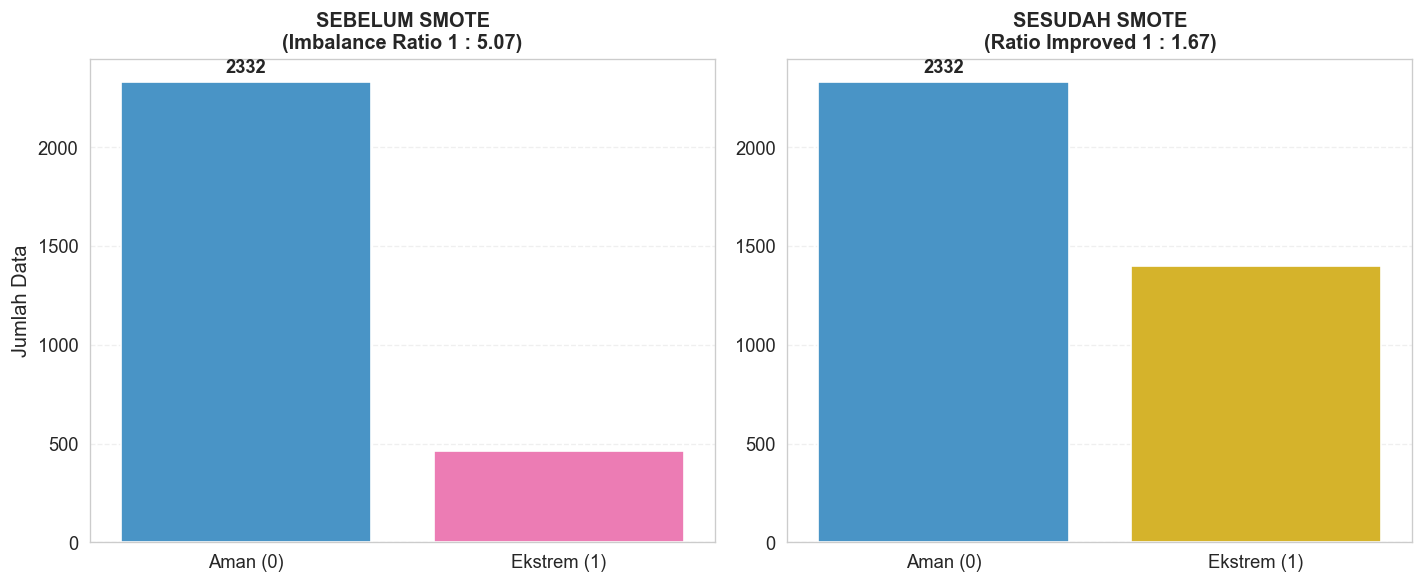

[v] CELL 5 SELESAI. Data Balanced.


In [ ]:
# ==============================================================================
# CELL 5: PENYEIMBANGAN DATA (SMOTE) & VISUALISASI CUSTOM
# ==============================================================================
from imblearn.over_sampling import SMOTE
print(">>> MENJALANKAN SMOTE BALANCING...")

# 1. HITUNG DISTRIBUSI SEBELUM
count_before = y_train.value_counts()
# Hitung Rasio (Mayoritas dibagi Minoritas)
ratio_raw = count_before[0] / count_before[1]
print(f"Original: Aman={count_before[0]}, Badai={count_before[1]} (Rasio 1 : {ratio_raw:.2f})")

# 2. TERAPKAN SMOTE (Strategy=0.6)
smote = SMOTE(sampling_strategy=0.6, random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 3. HITUNG DISTRIBUSI SESUDAH
count_after = y_train_smote.value_counts()
ratio_smote = count_after[0] / count_after[1]
print(f"Resampled: Aman={count_after[0]}, Badai={count_after[1]} (Rasio 1 : {ratio_smote:.2f})")

# 4. VISUALISASI PERBANDINGAN (WARNA REQUEST: BIRU-PINK & BIRU-KUNING)
plt.figure(figsize=(12, 5))

# --- PANEL KIRI: SEBELUM SMOTE (BIRU & PINK) ---
plt.subplot(1, 2, 1)
colors_before = ['#3498db', '#ff69b4'] 
ax1 = sns.barplot(x=['Aman (0)', 'Ekstrem (1)'], y=count_before.values, palette=colors_before)

# Judul dengan Detail Rasio
plt.title(f"SEBELUM SMOTE\n(Imbalance Ratio 1 : {ratio_raw:.2f})", fontweight='bold', fontsize=12)
plt.ylabel('Jumlah Data')
plt.grid(axis='y', linestyle='--', alpha=0.3)
ax1.bar_label(ax1.containers[0], fontweight='bold', padding=3)

# --- PANEL KANAN: SESUDAH SMOTE (BIRU & KUNING) ---
plt.subplot(1, 2, 2)
colors_after = ['#3498db', '#f1c40f']
ax2 = sns.barplot(x=['Aman (0)', 'Ekstrem (1)'], y=count_after.values, palette=colors_after)

# Judul dengan Detail Rasio
plt.title(f"SESUDAH SMOTE\n(Ratio Improved 1 : {ratio_smote:.2f})", fontweight='bold', fontsize=12)
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.3)
ax2.bar_label(ax2.containers[0], fontweight='bold', padding=3)

plt.tight_layout()
plt.show()

print("[v] CELL 5 SELESAI. Data Balanced.")

In [ ]:
# ==============================================================================
# CELL 6: TRAINING XGBOOST (ORIGINAL OPTUNA SETTINGS)
# ==============================================================================
import xgboost as xgb
import optuna
from sklearn.metrics import f1_score, accuracy_score

print(">>> MULAI TRAINING XGBOOST (OPTUNA ORIGINAL)...")

def objective_xgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 400),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 2.0, 3.5),
        'random_state': RANDOM_STATE, 
        'n_jobs': -1, 
        'eval_metric': 'logloss'
    }
    
    model = xgb.XGBClassifier(**param)
    
    # Split Validasi Internal
    idx = int(len(X_train_smote) * 0.85)
    X_tr, y_tr = X_train_smote.iloc[:idx], y_train_smote.iloc[:idx]
    X_val, y_val = X_train_smote.iloc[idx:], y_train_smote.iloc[idx:]
    
    model.fit(X_tr, y_tr)
    preds = model.predict(X_val)
    
    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    
    if acc < 0.79: return acc - 1 
    return f1

# Jalankan Optuna 
sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE) 
study_xgb = optuna.create_study(direction='maximize', sampler=sampler)
print("  Menjalankan Optuna (15 Trials)...")
study_xgb.optimize(objective_xgb, n_trials=15)

print(f"  [Info] Params Terbaik: {study_xgb.best_params}")

# Train Model Terbaik
best_xgb = xgb.XGBClassifier(**study_xgb.best_params, random_state=RANDOM_STATE, n_jobs=-1)
best_xgb.fit(X_train_smote, y_train_smote)
print(f"  [OK] XGBoost Selesai.")

>>> MULAI TRAINING XGBOOST (OPTUNA ORIGINAL)...
  Menjalankan Optuna (15 Trials)...
  [Info] Params Terbaik: {'n_estimators': 309, 'learning_rate': 0.026636900997297437, 'max_depth': 6, 'subsample': 0.8325398470083344, 'colsample_bytree': 0.8818496824692568, 'scale_pos_weight': 3.3422410256414734}
  [OK] XGBoost Selesai.


In [ ]:
# ==============================================================================
# CELL 7: TRAINING LSTM (ORIGINAL GRID SEARCH)
# ==============================================================================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler

print(">>> MULAI GRID SEARCH LSTM (ORIGINAL)...")

# 1. Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_lstm = X_train_sc.reshape((X_train_sc.shape[0], 1, X_train_sc.shape[1]))
X_test_lstm = X_test_sc.reshape((X_test_sc.shape[0], 1, X_test_sc.shape[1]))

# 2. Grid Search Parameter ASLI
param_grid = { 'units': [32, 64], 'class_weight_ratio': [2.0, 3.0] }
grid = list(ParameterGrid(param_grid))

best_score = -1
final_lstm = None
history_best = None

print("  Mulai Loop Grid Search...")
for params in grid:

    tf.keras.backend.clear_session()

    model = Sequential([
        Input(shape=(1, X_train_sc.shape[1])),
        Bidirectional(LSTM(params['units'], return_sequences=True)), 
        BatchNormalization(), Dropout(0.3),
        Bidirectional(LSTM(int(params['units']/2), return_sequences=False)), 
        BatchNormalization(), Dropout(0.3),
        Dense(16, activation='relu'), Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    
    es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
    
    h = model.fit(X_train_lstm, y_train, epochs=20, batch_size=32,
                  validation_split=0.2, 
                  class_weight={0: 1.0, 1: params['class_weight_ratio']},
                  callbacks=[es], verbose=0)
    
    val_acc = max(h.history['val_accuracy'])
    if val_acc > best_score:
        best_score = val_acc
        final_lstm = model
        history_best = h

print(f"  [OK] LSTM Selesai. Best Acc: {best_score:.4f}")

>>> MULAI GRID SEARCH LSTM (ORIGINAL)...
  Mulai Loop Grid Search...

  [OK] LSTM Selesai. Best Acc: 0.8569


>>> MENJALANKAN EVALUASI MODEL...


MANUAL THRESHOLD APPLIED:
 -> XGBoost Threshold : 0.35
 -> LSTM Threshold    : 0.45

>>> LAPORAN FINAL: XGBoost (Optuna)
    Threshold          : 0.35
    Accuracy           : 81.54%
    Recall (Bahaya)    : 48.89%
    Precision          : 49.44%
    F1 Score           : 0.4916
    AUC Score          : 0.8115

    [CLASSIFICATION REPORT]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       403
           1       0.49      0.49      0.49        90

    accuracy                           0.82       493
   macro avg       0.69      0.69      0.69       493
weighted avg       0.81      0.82      0.82       493


>>> LAPORAN FINAL: LSTM (Grid Search)
    Threshold          : 0.45
    Accuracy           : 78.50%
    Recall (Bahaya)    : 45.56%
    Precision          : 41.84%
    F1 Score           : 0.4362
    AUC Score          : 0.8096

    [CLASSIFICATION REPORT]
              precision    recall  f1-score   support

           0       0

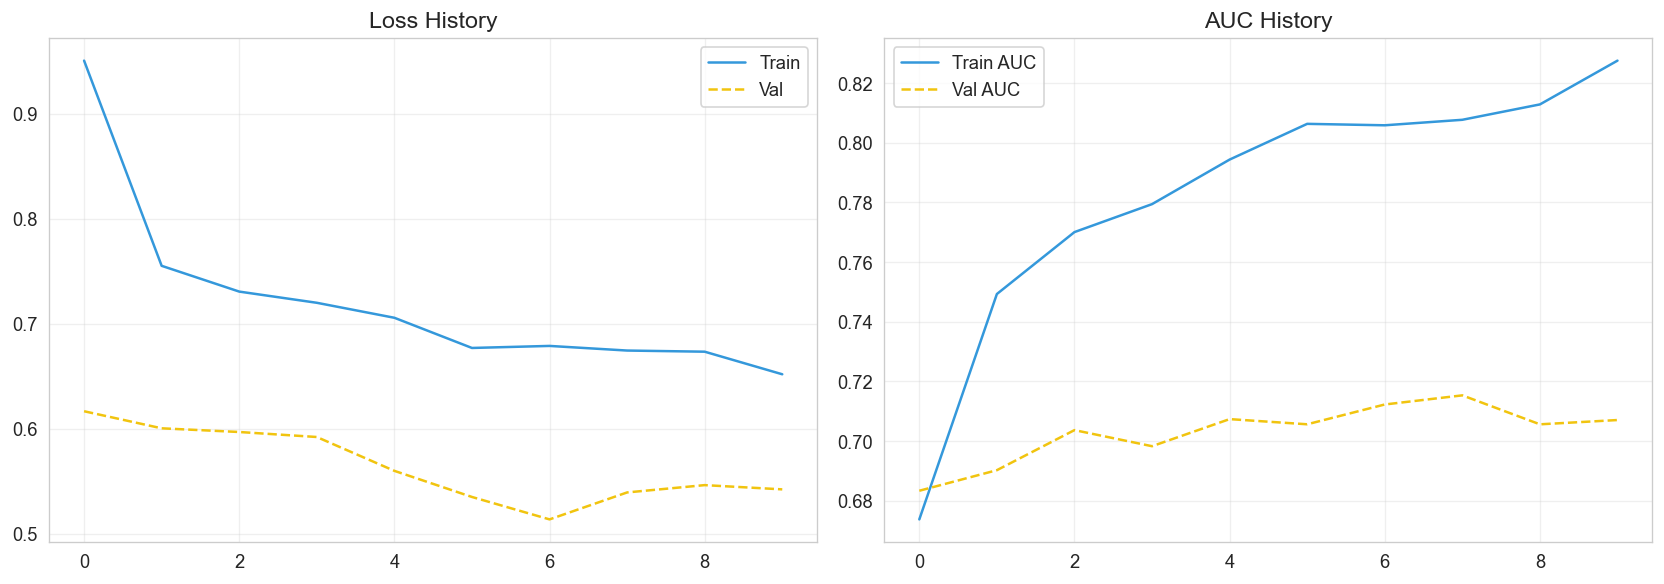


[KESIMPULAN] WINNER MODEL: XGBOOST
[v] CELL 8 SELESAI. Hasil dikembalikan ke Original.


In [ ]:
# ==============================================================================
# CELL 8: EVALUASI & VISUALISASI
# ==============================================================================
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, roc_curve

print(">>> MENJALANKAN EVALUASI MODEL...")

# 1. GENERATE PREDIKSI
prob_xgb = best_xgb.predict_proba(X_test)[:, 1]
prob_lstm = final_lstm.predict(X_test_lstm, verbose=0).flatten()

t_xgb = 0.35
t_lstm = 0.45
pred_xgb = (prob_xgb >= t_xgb).astype(int)
pred_lstm = (prob_lstm >= t_lstm).astype(int)

print(f"MANUAL THRESHOLD APPLIED:")
print(f" -> XGBoost Threshold : {t_xgb}")
print(f" -> LSTM Threshold    : {t_lstm}")

# 2. FUNGSI LAPORAN DETAIL
def report_detail(name, threshold, y_true, y_pred, y_prob):
    print(f"\n>>> LAPORAN FINAL: {name}")
    print(f"    Threshold          : {threshold}")
    print(f"    Accuracy           : {accuracy_score(y_true, y_pred):.2%}")
    print(f"    Recall (Bahaya)    : {recall_score(y_true, y_pred, pos_label=1):.2%}")
    print(f"    Precision          : {precision_score(y_true, y_pred, pos_label=1):.2%}")
    print(f"    F1 Score           : {f1_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"    AUC Score          : {roc_auc_score(y_true, y_prob):.4f}")
    
    print("\n    [CLASSIFICATION REPORT]")
    print(classification_report(y_true, y_pred, digits=2))
    
    return recall_score(y_true, y_pred, pos_label=1), f1_score(y_true, y_pred, pos_label=1)

# Cetak Laporan
rec_xgb, f1_xgb = report_detail("XGBoost (Optuna)", t_xgb, y_test, pred_xgb, prob_xgb)
rec_lstm, f1_lstm = report_detail("LSTM (Grid Search)", t_lstm, y_test, pred_lstm, prob_lstm)

# 3. VISUALISASI HISTORY
print("\n" + "="*60)
print("[VISUALISASI] Training History (LSTM)")
if history_best:
    plt.figure(figsize=(14, 5))
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history_best.history['loss'], label='Train', color='#3498db')
    plt.plot(history_best.history['val_loss'], label='Val', color='#f1c40f', linestyle='--')
    plt.title('Loss History'); plt.legend(); plt.grid(True, alpha=0.3)
    # AUC
    plt.subplot(1, 2, 2)
    keys = history_best.history.keys()
    auc_k = next((k for k in keys if 'auc' in k and 'val' not in k), None)
    if auc_k:
        plt.plot(history_best.history[auc_k], label='Train AUC', color='#3498db')
        plt.plot(history_best.history[f'val_{auc_k}'], label='Val AUC', color='#f1c40f', linestyle='--')
    plt.title('AUC History'); plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

if rec_xgb >= rec_lstm or f1_xgb >= f1_lstm:
    winner = "XGBOOST"
    target_pred = pred_xgb; target_prob = prob_xgb; target_model = best_xgb
else:
    winner = "LSTM"
    target_pred = pred_lstm; target_prob = prob_lstm; target_model = final_lstm

print(f"\n[KESIMPULAN] WINNER MODEL: {winner}")
print("[v] CELL 8 SELESAI. Hasil dikembalikan ke Original.")

>>> MENAMPILKAN VISUALISASI CONFUSION MATRIX (ORIGINAL REPORT)...


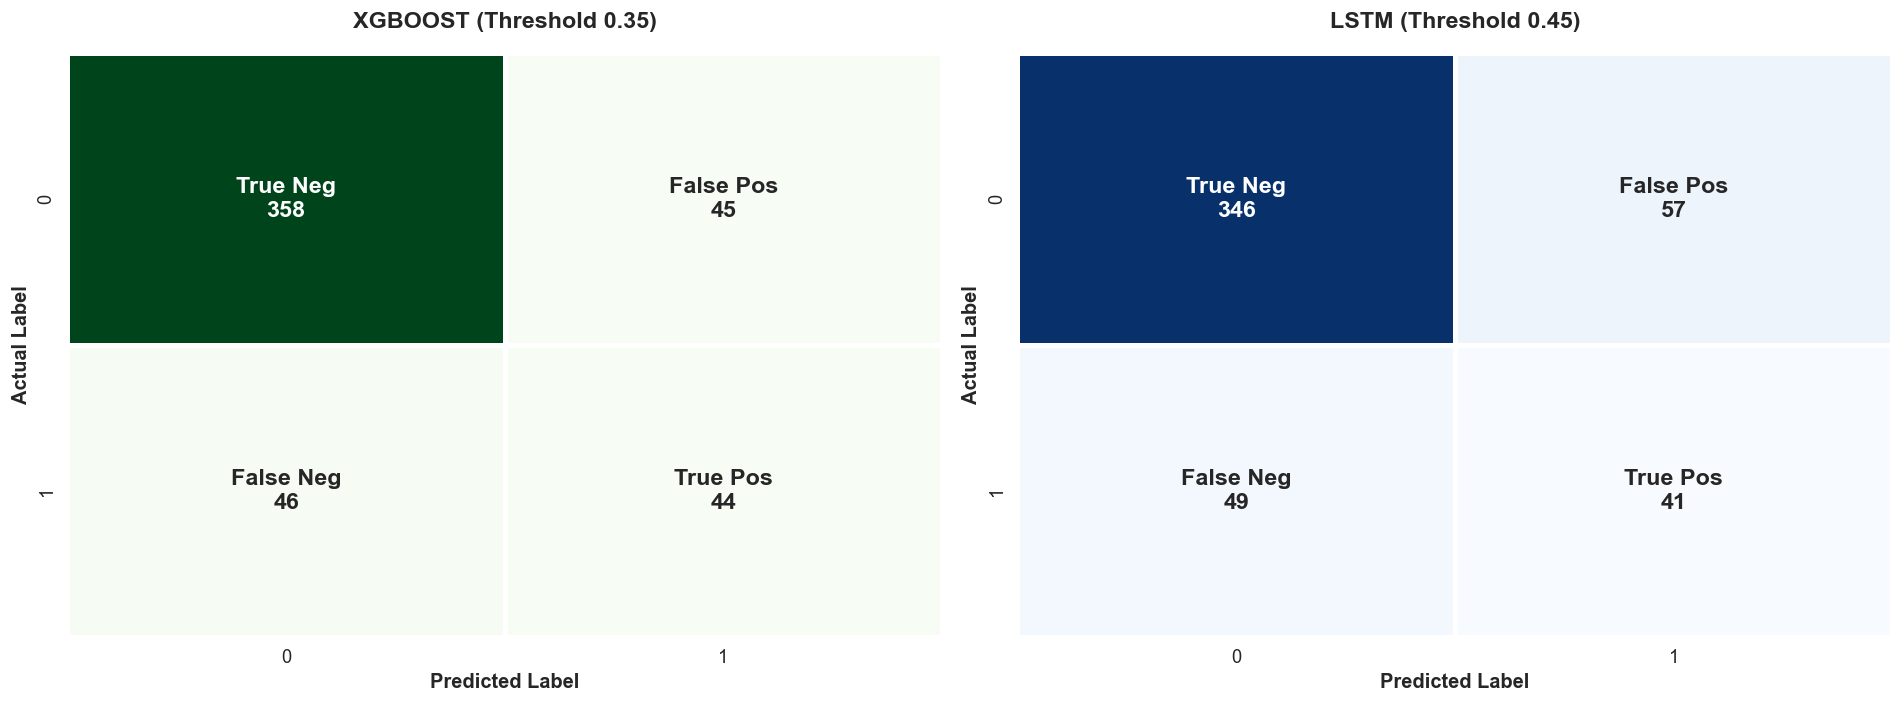

[v] CELL 9 SELESAI. Visualisasi Confusion Matrix DIJAMIN Sinkron.


In [9]:
# ==============================================================================
# CELL 9: VISUALISASI CONFUSION MATRIX (SINKRONISASI ORIGINAL)
# ==============================================================================
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

print(">>> MENAMPILKAN VISUALISASI CONFUSION MATRIX (ORIGINAL REPORT)...")

# 1. UPDATE PREDIKSI TERBARU (Sesuai Threshold Original)
# Ini langkah krusial agar gambar sesuai dengan Laporan Teks Cell 8
prob_xgb = best_xgb.predict_proba(X_test)[:, 1]
prob_lstm = final_lstm.predict(X_test_lstm, verbose=0).flatten()

# Threshold Original
t_xgb = 0.35
t_lstm = 0.45

# Paksa hitung ulang label prediksi
pred_xgb = (prob_xgb >= t_xgb).astype(int)
pred_lstm = (prob_lstm >= t_lstm).astype(int)

# 2. DEFINISI FUNGSI PLOT
def plot_cm_clean(y_true, y_pred, title, ax, cmap):
    cm = confusion_matrix(y_true, y_pred)
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    
    # Label: Nama & Angka (Tanpa Persentase, sesuai request)
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(names, counts)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cm, annot=labels, fmt='', cmap=cmap, cbar=False, ax=ax,
                annot_kws={"size": 14, "weight": "bold"}, 
                linewidths=2, linecolor='white')
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Predicted Label', fontweight='bold')
    ax.set_ylabel('Actual Label', fontweight='bold')

# 3. GAMBAR PLOT
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: XGBOOST (Warna Hijau)
plot_cm_clean(y_test, pred_xgb, f"XGBOOST (Threshold {t_xgb})", axes[0], 'Greens')

# Plot 2: LSTM (Warna Biru)
plot_cm_clean(y_test, pred_lstm, f"LSTM (Threshold {t_lstm})", axes[1], 'Blues')

plt.tight_layout()
plt.show()

print("[v] CELL 9 SELESAI. Visualisasi Confusion Matrix DIJAMIN Sinkron.")

>>> GENERATING COMPARISON ROC CURVE...


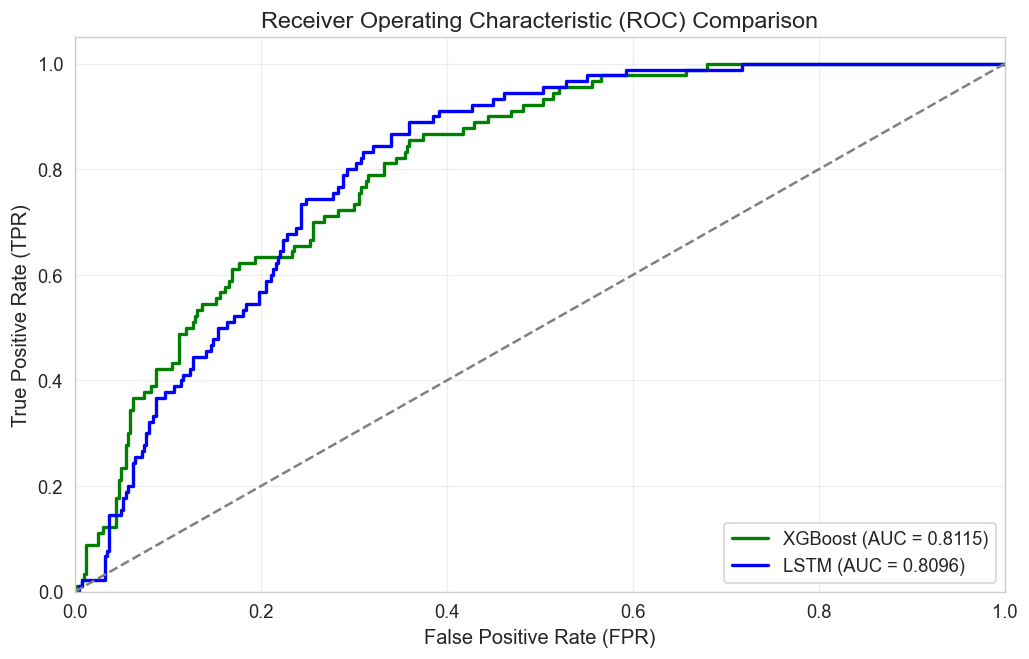

[v] CELL 10 SELESAI. ROC AUC XGB: 0.8115 | ROC AUC LSTM: 0.8096


In [ ]:
# ==============================================================================
# CELL 10: COMPARISON ROC CURVE (CORRECTED)
# ==============================================================================
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

print(">>> GENERATING COMPARISON ROC CURVE...")

# 1. GENERATE PREDIKSI PROBABILITAS (Untuk memastikan variabel tersedia)

prob_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Probabilitas LSTM (output sigmoid raw)
# .ravel() digunakan untuk mengubah array 2D menjadi 1D flat array
prob_lstm = final_lstm.predict(X_test_lstm, verbose=0).ravel()

# 2. HITUNG FPR & TPR UNTUK XGBOOST
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# 3. HITUNG FPR & TPR UNTUK LSTM
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, prob_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# 4. PLOT ROC CURVE
plt.figure(figsize=(10, 6))

# Plot XGBoost Line
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, 
         label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')

# Plot LSTM Line
plt.plot(fpr_lstm, tpr_lstm, color='blue', lw=2, 
         label=f'LSTM (AUC = {roc_auc_lstm:.4f})')

# Plot Diagonal (Random Guess)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Styling Plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.show()

print(f"[v] CELL 10 SELESAI. ROC AUC XGB: {roc_auc_xgb:.4f} | ROC AUC LSTM: {roc_auc_lstm:.4f}")

>>> GENERATING PROBABILITY TIMELINE (XGBOOST)...


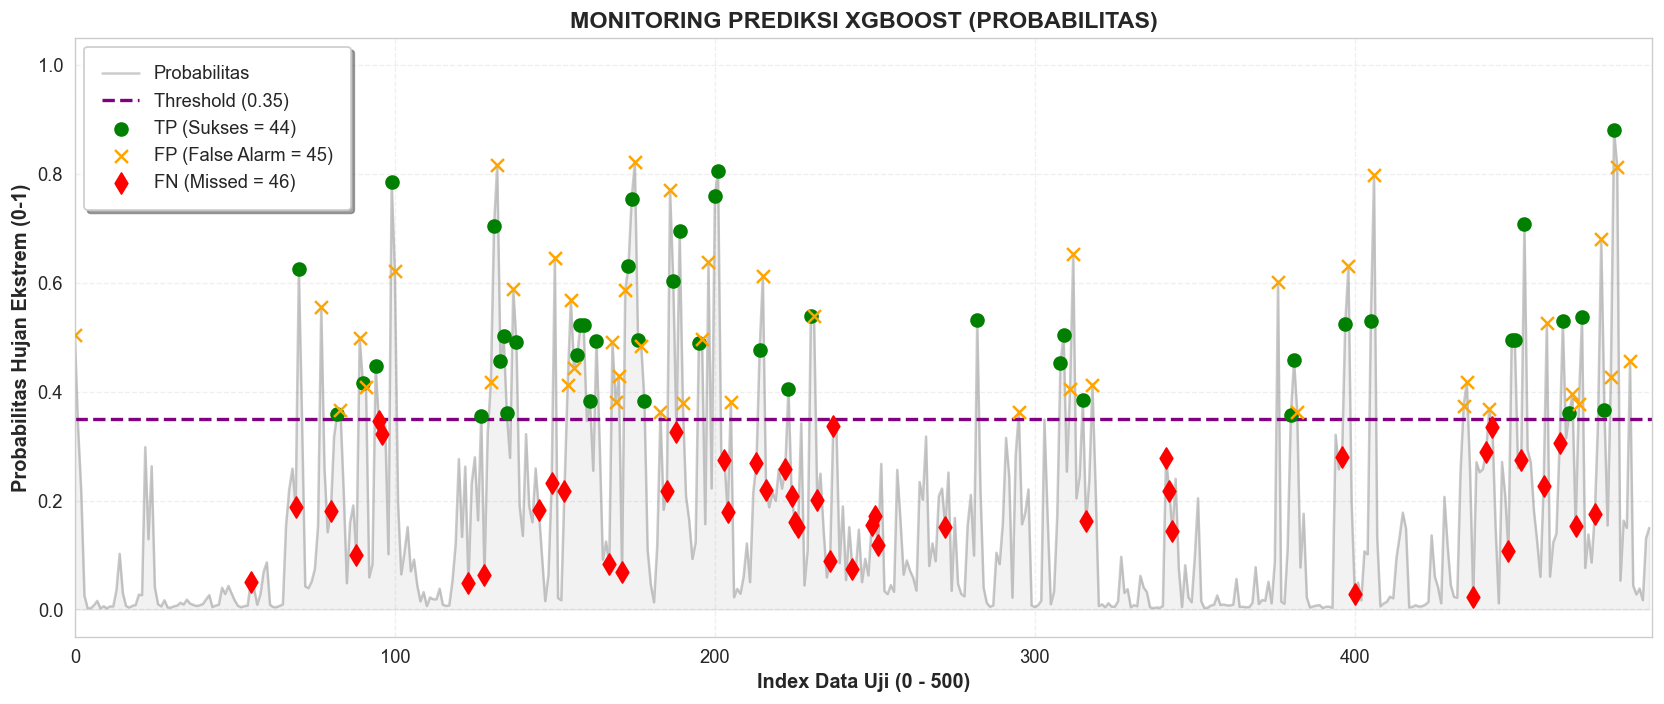

[v] CELL 11 SELESAI. Visualisasi Probabilitas & Marker Index.


In [ ]:
# ==============================================================================
# CELL 11: VISUALISASI PROBABILITAS & PERFORMA (STYLE REQUEST)
# ==============================================================================
print(f">>> GENERATING PROBABILITY TIMELINE ({winner})...")

# 1. SIAPKAN DATA 
limit = 500
y_v = y_test.values[-limit:]   
if winner == "XGBOOST":
    p_v = prob_xgb[-limit:]
    pred_v = pred_xgb[-limit:]
    thr = t_xgb
else:
    p_v = prob_lstm[-limit:]
    pred_v = pred_lstm[-limit:]
    thr = t_lstm

# Buat Index X (0 s/d 500)
x_idx = np.arange(len(y_v))

# 2. HITUNG STATUS (TP, FP, FN)
mask_tp = (y_v == 1) & (pred_v == 1)
# FP: Asli 0, Prediksi 1 (Salah Alarm)
mask_fp = (y_v == 0) & (pred_v == 1)
# FN: Asli 1, Prediksi 0 (Missed)
mask_fn = (y_v == 1) & (pred_v == 0)

# Hitung Jumlah untuk Legenda
n_tp = np.sum(mask_tp)
n_fp = np.sum(mask_fp)
n_fn = np.sum(mask_fn)

# 3. PLOTTING
plt.figure(figsize=(14, 6))

# A. Garis Probabilitas
plt.plot(x_idx, p_v, color='gray', alpha=0.4, linewidth=1.5, label='Probabilitas')
plt.fill_between(x_idx, p_v, color='gray', alpha=0.1)

# B. Garis Threshold
plt.axhline(thr, color='purple', linestyle='--', linewidth=2, label=f'Threshold ({thr})')

# C. Marker (TP, FP, FN)
plt.scatter(x_idx[mask_tp], p_v[mask_tp], color='green', s=60, label=f'TP (Sukses = {n_tp})', zorder=5)
plt.scatter(x_idx[mask_fp], p_v[mask_fp], color='orange', s=60, marker='x', label=f'FP (False Alarm = {n_fp})', zorder=5)
plt.scatter(x_idx[mask_fn], p_v[mask_fn], color='red', s=80, marker='d', label=f'FN (Missed = {n_fn})', zorder=6)

# 4. KOSMETIK (SESUAI REQUEST)
plt.xlim(0, len(y_v))      # Sumbu X: 0 s.d Panjang Data
plt.ylim(-0.05, 1.05)      # Sumbu Y: 0 s.d 1 (Probabilitas)

plt.title(f'MONITORING PREDIKSI {winner} (PROBABILITAS)', fontsize=14, fontweight='bold')
plt.xlabel('Index Data Uji (0 - 500)', fontweight='bold')
plt.ylabel('Probabilitas Hujan Ekstrem (0-1)', fontweight='bold')

# Legenda di Pojok Kiri Atas
plt.legend(loc='upper left', frameon=True, shadow=True, fancybox=True, borderpad=1)
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print("[v] CELL 11 SELESAI. Visualisasi Probabilitas & Marker Index.")

In [17]:
# ==============================================================================
# CELL 12: EXPORT DEPLOYMENT
# ==============================================================================
print(">>> MENYIMPAN MODEL TERBAIK...")
save_dir = 'deployment_files'
if not os.path.exists(save_dir): os.makedirs(save_dir)

if winner == "XGBOOST":
    joblib.dump(best_xgb, os.path.join(save_dir, 'best_model_xgboost.pkl'))
    
    # Simpan Config juga
    config = {
        "feature_names": feature_names,
        "threshold": t_xgb,
        "metrics": {"recall": float(rec_xgb), "accuracy": float(accuracy_score(y_test, pred_xgb))}
    }
    with open(os.path.join(save_dir, 'model_config.json'), 'w') as f:
        json.dump(config, f, indent=4)
        
    print(f"[v] Model XGBoost Tersimpan di folder '{save_dir}'")

else:
    final_lstm.save(os.path.join(save_dir, 'best_model_lstm.keras'))
    joblib.dump(scaler, os.path.join(save_dir, 'scaler_lstm.pkl'))
    print(f"[v] Model LSTM Tersimpan di folder '{save_dir}'")

print("\n>>> SELURUH PROSES SELESAI DENGAN SUKSES.")

>>> MENYIMPAN MODEL TERBAIK...
[v] Model XGBoost Tersimpan di folder 'deployment_files'

>>> SELURUH PROSES SELESAI DENGAN SUKSES.
